In [1]:
initialized = False

In [2]:
import os
if(initialized == False):
    os.chdir('..')
    initialized = True

# Here we will learn to generate faces in 1 minutes
### This code was run on 1 NVIDIA 1080Ti

In [4]:
import src.flows as nux
import haiku as hk
import jax
from jax import random, vmap, jit
import jax.numpy as jnp
from jax.experimental import optimizers
import tensorflow_datasets as tfds
import tensorflow as tf
import tqdm
from functools import partial
import src.util as util
import matplotlib.pyplot as plt

# Create a simple NIF

In [5]:
def gen_flow(quantize_bits=3):

    layers = [nux.Coupling(hidden_layer_sizes=[1024]*4), nux.Reverse()]*3
    prior_flow = nux.sequential(*layers)

    flow = nux.sequential(nux.UniformDequantization(scale=2**quantize_bits),
                          nux.Logit(),
                          nux.Flatten(),
                          nux.TallAffineDiagCov(64),
                          prior_flow,
                          nux.UnitGaussianPrior())
    return flow

# Load the dataset

In [6]:
def central_crop(x):
    x['image'] = x['image'][::2,::2][26:-19,12:-13]
    return x

def quantize(x, quantize_bits):
    quantize_factor = 256/(2**quantize_bits)
    x['image'] = x['image']//tf.cast(quantize_factor, dtype=tf.uint8)
    return x

def load_dataset(split='train', is_training=True, batch_size=32, quantize_bits=3):
    ds = tfds.load('celeb_a', split=split).repeat()
    ds = ds.map(central_crop)
    ds = ds.map(partial(quantize, quantize_bits=quantize_bits))
    if is_training:
        ds = ds.shuffle(10*batch_size, seed=0)
    ds = ds.batch(batch_size)
    return tfds.as_numpy(ds)

# Initialize the model

In [7]:
quantize_bits = 3
ds = load_dataset(quantize_bits=quantize_bits)

x = next(ds)['image']*1.0
inputs = {'x': x}

key = random.PRNGKey(0)
init_fun = gen_flow(quantize_bits=quantize_bits)
_, flow = init_fun(key, inputs, batched=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/home/eddie/anaconda3/envs/flow/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


# Create the loss function

In [8]:
@partial(jit, static_argnums=(0,))
def nll(apply, params, state, inputs, **kwargs):
    outputs, updated_state = apply(params, state, inputs, **kwargs)
    log_px = outputs['log_det']
    return -jnp.mean(log_px), updated_state

In [9]:
clip_grads = jit(optimizers.clip_grads)

class Model():
    def __init__(self, flow):
        self.flow = flow
        self.loss = partial(nll, partial(flow.apply, reverse=False))
        self.valgrad = jax.value_and_grad(self.loss, has_aux=True)
        self.valgrad = jit(self.valgrad)
        self.ewma_params = flow.params
        
        opt_init, opt_update, get_params = optimizers.adam(1e-3)
        self.opt_update = jit(opt_update)
        self.get_params = jit(get_params)
        self.opt_state = opt_init(flow.params)
        
        self.training_steps = 0
        self.losses = []
        
    def grad_step(self, key, inputs):
        (val, state), grad = self.valgrad(self.flow.params, self.flow.state, inputs, key=key)
        grad = clip_grads(grad, 5.0)
        
        self.opt_state = self.opt_update(self.training_steps, grad, self.opt_state)
        self.training_steps += 1
        
        self.flow = self.flow._replace(params=self.get_params(self.opt_state), state=state)
        
        bits_per_dim = val/jnp.prod(self.flow.input_shapes['x'])/jnp.log(2)
        self.losses.append(bits_per_dim)
        return bits_per_dim
    
    def sample(self, key, n_samples):
        z = random.normal(key, (n_samples,) + self.flow.output_shapes['x'])
        
        self.flow.state['tall_affine_diag_cov']['sigma'] = 0.0
        outputs, _ = self.flow.apply(self.flow.params, self.flow.state, {'x': z}, key=key, reverse=True)
        self.flow.state['tall_affine_diag_cov']['sigma'] = 1.0
        
        fz = outputs['x']

        # Undo the dequantization and logit scaling to make sure we end up between 0 and 1
        fz /= (2.0**quantize_bits)
        fz *= (1.0 - 2*0.05) # This is the default scaling using in nux.Logit
        fz += 0.05
        return fz
    
NIF = Model(flow)

# Train

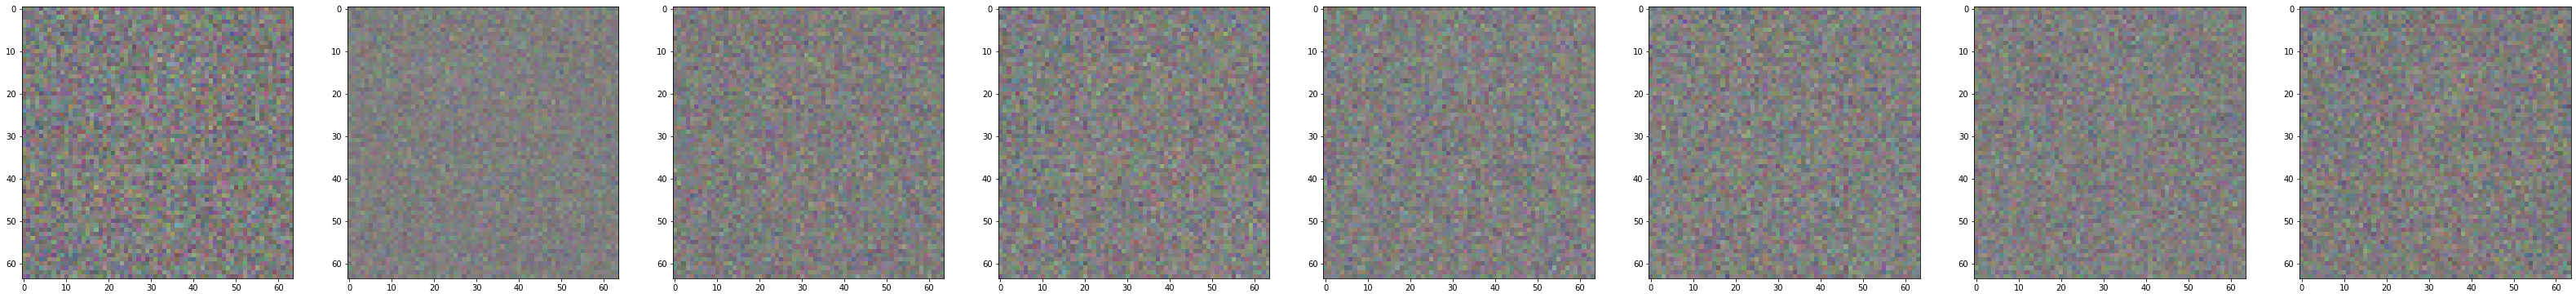

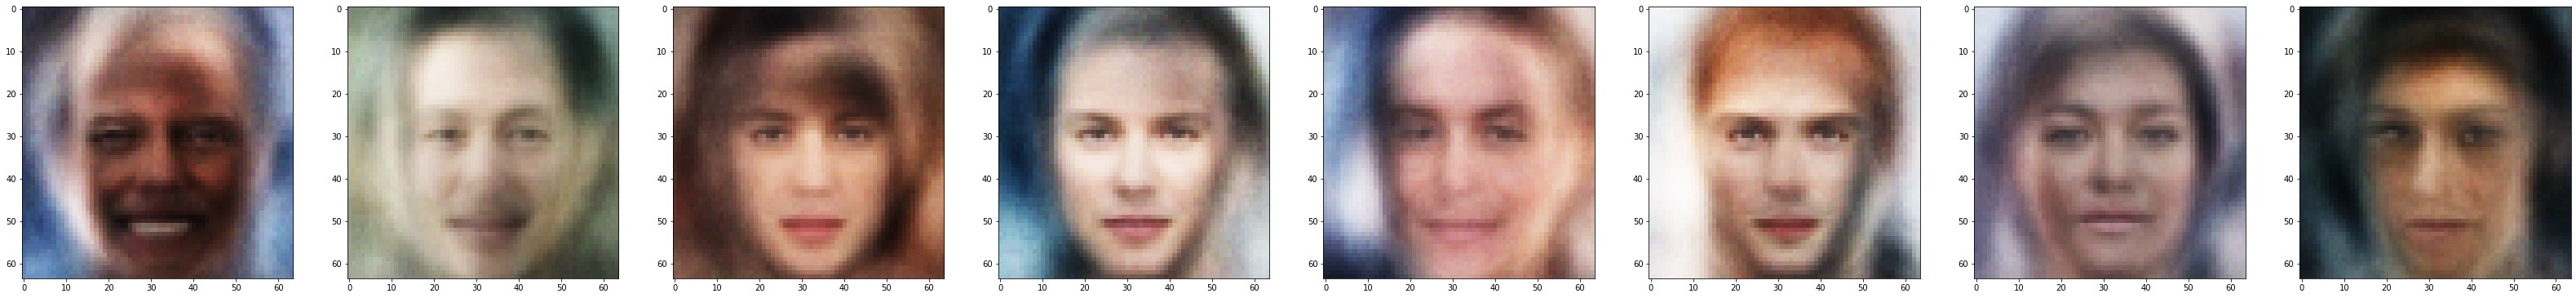

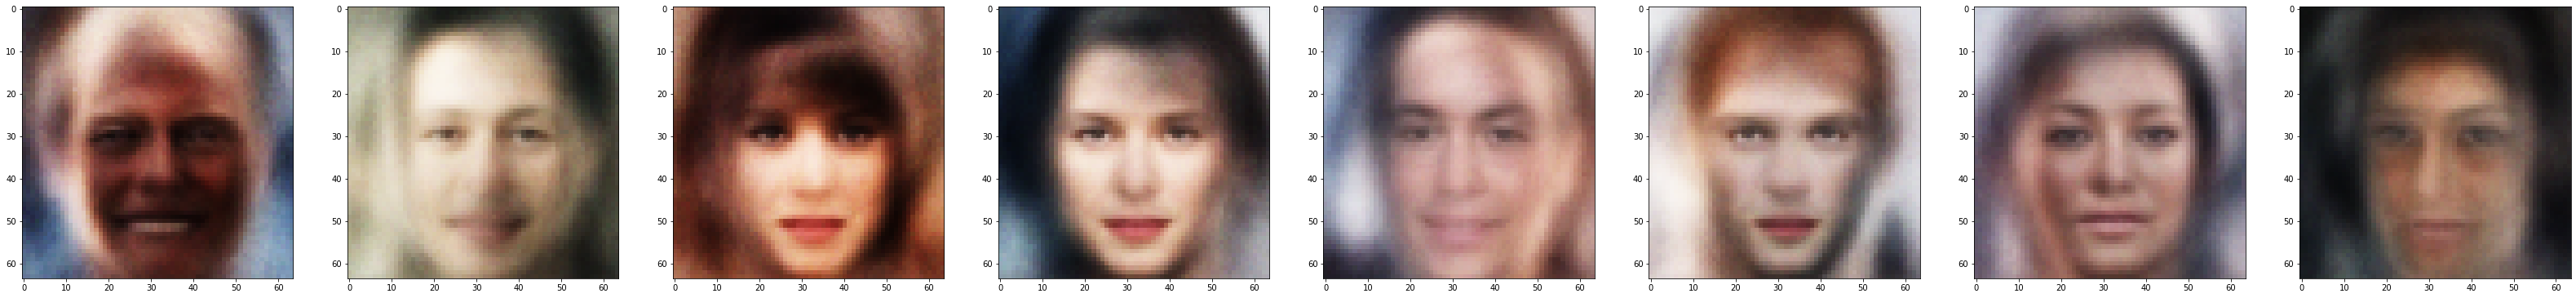

In [10]:
batch_size = 32
n_iters = 2000
keys = random.split(key, n_iters)
pbar = tqdm.notebook.tqdm(enumerate(keys), total=n_iters)
for i, key in pbar:
    x_batch = next(ds)['image']
    inputs = {'x': x_batch}
    
    # Take a gradient step
    val = NIF.grad_step(key, inputs)
    
    pbar.set_description('bits/dim: %5.3f'%(val))

    if(i%1000 == 0 or i == n_iters - 1):
        eval_key = random.PRNGKey(1)
        n_samples = 8
        
        fz = NIF.sample(eval_key, n_samples)

        # Plot the samples
        fig, axes = plt.subplots(1, n_samples, figsize=(7*n_samples, 7)); axes=axes.ravel()
        for i, ax in enumerate(axes):
            ax.imshow(fz[i])
        plt.show()

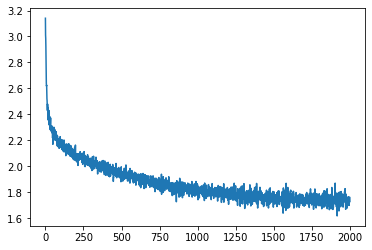

In [11]:
plt.plot(NIF.losses)